In [3]:
import os
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-5.3.0-posix-seh-rt_v4-rev0\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

In [17]:
import pandas as pd
import numpy as np
from math import ceil

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

import xgboost as xgb

In [11]:
#load data
train = pd.concat([pd.read_csv('test_xgb_boruta_big.csv'),pd.read_csv('test_xgb_EngFeat.csv'),
                   pd.read_csv('test_xgb_ExtraTreesFeat.csv'),
                   pd.read_csv('test_xgb_ExtraTreesFeat_newFeat.csv'),
                   pd.read_csv('test_xgb_ExtraTreesFeat_newFeat2.csv'),
                   pd.read_csv('test_xgb_polynomial.csv'),
                   pd.read_csv('test_xgb_polynomial_gblinear.csv'),
                   pd.read_csv('test_xgb_SDV.csv')], axis = 1)
                   
test = pd.concat([pd.read_csv('submission_xgb_boruta_big.csv')['TARGET'],
                  pd.read_csv('submission_xgb_EngFeat.csv')['TARGET'],
                  pd.read_csv('submission_xgb_ExtraTreesFeat.csv')['TARGET'],
                  pd.read_csv('submission_xgb_ExtraTreesFeat_newFeat.csv')['TARGET'],
                  pd.read_csv('submission_xgb_ExtraTreesFeat_newFeat2.csv')['TARGET'],
                  pd.read_csv('submission_xgb_polynomial.csv')['TARGET'],
                  pd.read_csv('submission_xgb_polynomial_gblinear.csv')['TARGET'],
                  pd.read_csv('submission_xgb_svd.csv')['TARGET']], axis = 1)

train.columns = ['boruta', 'EngFeat', 'ETrees', 'ETreesNF', 'ETreesNF2', 'poly', 'poly_linear', 'svd']
test.columns = ['boruta', 'EngFeat', 'ETrees', 'ETreesNF', 'ETreesNF2', 'poly', 'poly_linear', 'svd']

# to divide and get the label
y_target = pd.read_csv('test_label.csv')
test_id = pd.read_csv('test.csv')['ID']

In [8]:
train.head(), test.head()

(     boruta   EngFeat    ETrees  ETreesNF  ETreesNF2      poly  poly_linear  \
 0  0.023971  0.015223  0.013046  0.017138   0.015207  0.006922     0.009351   
 1  0.003546  0.005303  0.005315  0.004979   0.005631  0.004093     0.008948   
 2  0.004870  0.005303  0.005315  0.004979   0.005631  0.004093     0.008672   
 3  0.019456  0.021230  0.020812  0.019699   0.020776  0.018011     0.011964   
 4  0.013319  0.014400  0.014114  0.014493   0.015311  0.011185     0.036514   
 
         svd  
 0  0.007318  
 1  0.004297  
 2  0.004297  
 3  0.007394  
 4  0.019551  ,
      boruta   EngFeat    ETrees  ETreesNF  ETreesNF2      poly  poly_linear  \
 0  0.037514  0.047195  0.059054  0.048444   0.033028  0.035683     0.021486   
 1  0.037514  0.054622  0.059349  0.055090   0.044017  0.065512     0.025933   
 2  0.003572  0.004777  0.003721  0.003450   0.005882  0.007006     0.013641   
 3  0.008018  0.014400  0.014114  0.011722   0.011987  0.011185     0.030427   
 4  0.002527  0.005303  0.0

In [9]:
train.shape, test.shape

((38010, 8), (75818, 8))

In [15]:
for col in train.columns:
    print(col,': ', roc_auc_score(y_target, train[col], average='macro'))

boruta :  0.829622196043
EngFeat :  0.828572172083
ETrees :  0.830361409615
ETreesNF :  0.830697730326
ETreesNF2 :  0.831721767989
poly :  0.814209356443
poly_linear :  0.781726760214
svd :  0.784980978653


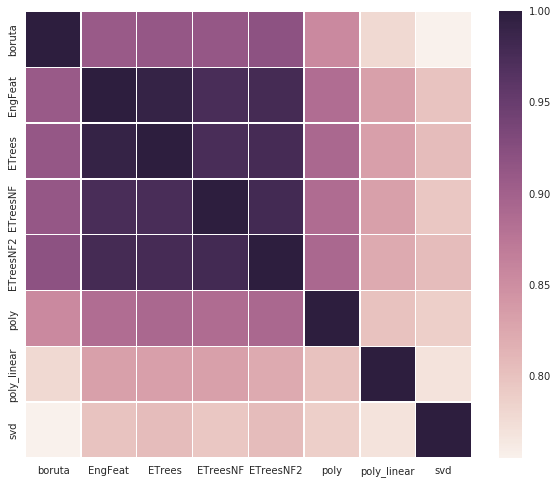

In [19]:
cor_mat = train.corr()

f, ax = plt.subplots(figsize=(10, 8))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(cor_mat,linewidths=.5, ax=ax)

In [24]:
## Model 1: Train Model

# generate sparse matrices
dtrain = xgb.DMatrix(train, label = y_target)
#dtest = xgb.DMatrix(X_test, label = y_test)

dtest_sub = xgb.DMatrix(test)

# do crossvalidation
print ('running cross validation')
param = {'max_depth':4, 'eta':1, 'silent':0, 'objective':'binary:logistic'}
num_round = 10

model_cv = xgb.cv(param, dtrain, num_round, nfold = 5,  metrics={'auc'}, seed = 0)
print(model_cv.T.T)
bestIter = model_cv.T.loc['test-auc-mean'].idxmax()
print("Best Interaction: ", bestIter)

#xgb_model = xgb.train(param, dtrain, num_round, watchlist)
#prediction = xgb_model.predict(dtest)
#print('Best Inter: ', xgb_model.best_iteration)
#print("Roc AUC test: ", roc_auc_score(y_test, prediction, average='macro'))

running cross validation
   test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0       0.822256      0.009467        0.826885       0.001757
1       0.830678      0.009224        0.841550       0.001959
2       0.830921      0.008199        0.847382       0.002236
3       0.831024      0.008368        0.852329       0.001817
4       0.828709      0.009427        0.856245       0.002446
5       0.826863      0.010209        0.859630       0.003278
6       0.826861      0.010411        0.862819       0.003461
7       0.826787      0.009864        0.864791       0.003137
8       0.824452      0.009677        0.867470       0.003235
9       0.823263      0.009775        0.869946       0.003445
Best Interaction:  3


In [28]:
# submission
prediction = np.zeros(test.shape[0])
for seed_set in [1,2,3,4,5,6,7,8,9,10]:
    xgb_extraTreesParam = xgb.train(param, dtrain, num_round)
    prediction = prediction + xgb_extraTreesParam.predict(dtest_sub)

prediction = prediction/10
#prediction = xgb_extraTreesParam.predict(dtest_sub)
submission = pd.DataFrame({"ID":test_id, "TARGET": prediction})
submission.to_csv("submission_xgb_Final.csv", index=False)